### Objective
- Use the customer information provided to group them into segments

In [481]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

### Data loading and pre-processing

In [482]:
# Load data set
customer_data = pd.read_csv("customers.csv")
customer_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [483]:
# Check shape
customer_data.shape

(8068, 11)

In [484]:
# Check datatypes & counts
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [485]:
# Identify any missing data
customer_data.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [486]:
# Drop all the rows with missing data
customer_data = customer_data.dropna()

In [487]:
# Drop segmentation column
# We want to determine if there is a particular type of grouping ourselves
customer_data = customer_data.drop("Segmentation", axis=1)
customer_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6


In [488]:
# Check unique values in columns we are encoding
print(customer_data["Gender"].unique())
print(customer_data["Ever_Married"].unique())
print(customer_data["Graduated"].unique())
print(customer_data["Profession"].unique())
print(customer_data["Spending_Score"].unique())
print(customer_data["Var_1"].unique())

['Male' 'Female']
['No' 'Yes']
['No' 'Yes']
['Healthcare' 'Engineer' 'Lawyer' 'Artist' 'Doctor' 'Homemaker'
 'Entertainment' 'Marketing' 'Executive']
['Low' 'High' 'Average']
['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' 'Cat_5']


In [489]:
# Encode categorical columns
label_encoder_gender = LabelEncoder()
label_encoder_ever_married = LabelEncoder()
label_encoder_graduated = LabelEncoder()
label_encoder_profession = LabelEncoder()
label_encoder_spending_score = LabelEncoder()
label_encoder_var_1 = LabelEncoder()

customer_data["Gender"] = label_encoder_gender.fit_transform(customer_data["Gender"])
customer_data["Ever_Married"] = label_encoder_graduated.fit_transform(
    customer_data["Ever_Married"]
)
customer_data["Graduated"] = label_encoder_graduated.fit_transform(
    customer_data["Graduated"]
)
customer_data["Profession"] = label_encoder_graduated.fit_transform(
    customer_data["Profession"]
)
customer_data["Spending_Score"] = label_encoder_spending_score.fit_transform(
    customer_data["Spending_Score"]
)
customer_data["Var_1"] = label_encoder_spending_score.fit_transform(
    customer_data["Var_1"]
)

In [490]:
# Descriptive statistics
customer_data.describe()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
count,6665.00000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000
mean,463519.84096,0.551688,0.591748,43.536084,0.637509,2.700975,2.629107,1.350638,2.841110,4.178395
std,2566.43174,0.497358,0.491547,16.524054,0.480755,2.519285,3.405365,0.852364,1.524743,1.409265
min,458982.00000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,461349.00000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000
50%,463575.00000,1.000000,1.000000,41.000000,1.000000,2.000000,1.000000,2.000000,2.000000,5.000000
75%,465741.00000,1.000000,1.000000,53.000000,1.000000,5.000000,4.000000,2.000000,4.000000,5.000000
max,467974.00000,1.000000,1.000000,89.000000,1.000000,8.000000,14.000000,2.000000,9.000000,6.000000


### Data Exploration

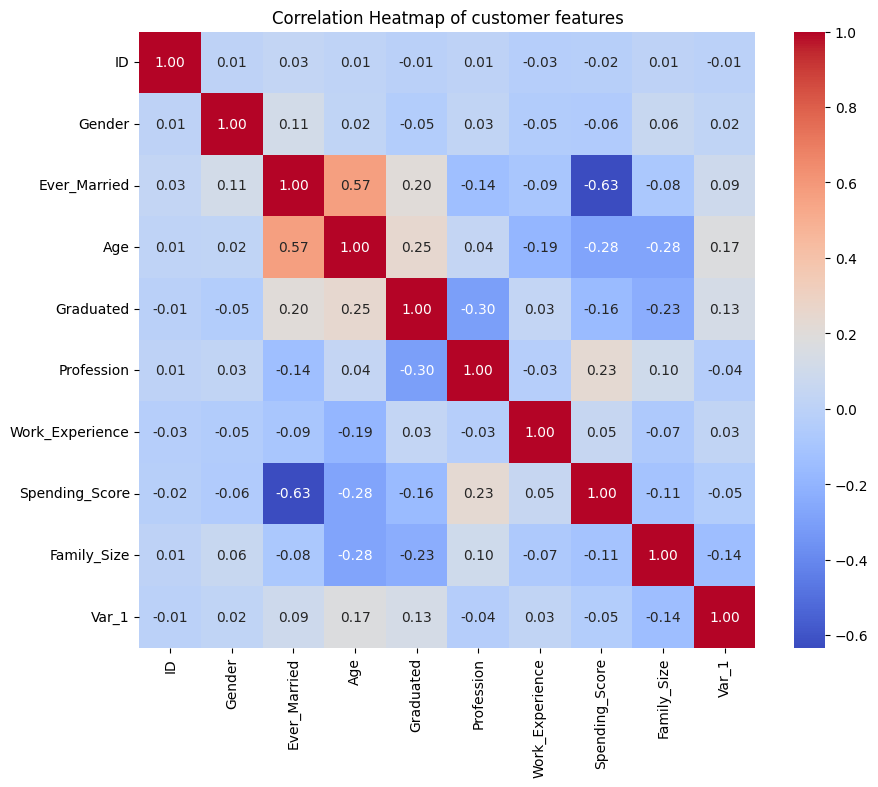

In [491]:
# Correlation map of features to explore relationships between features
correlation_matrix = customer_data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of customer features")
plt.show()

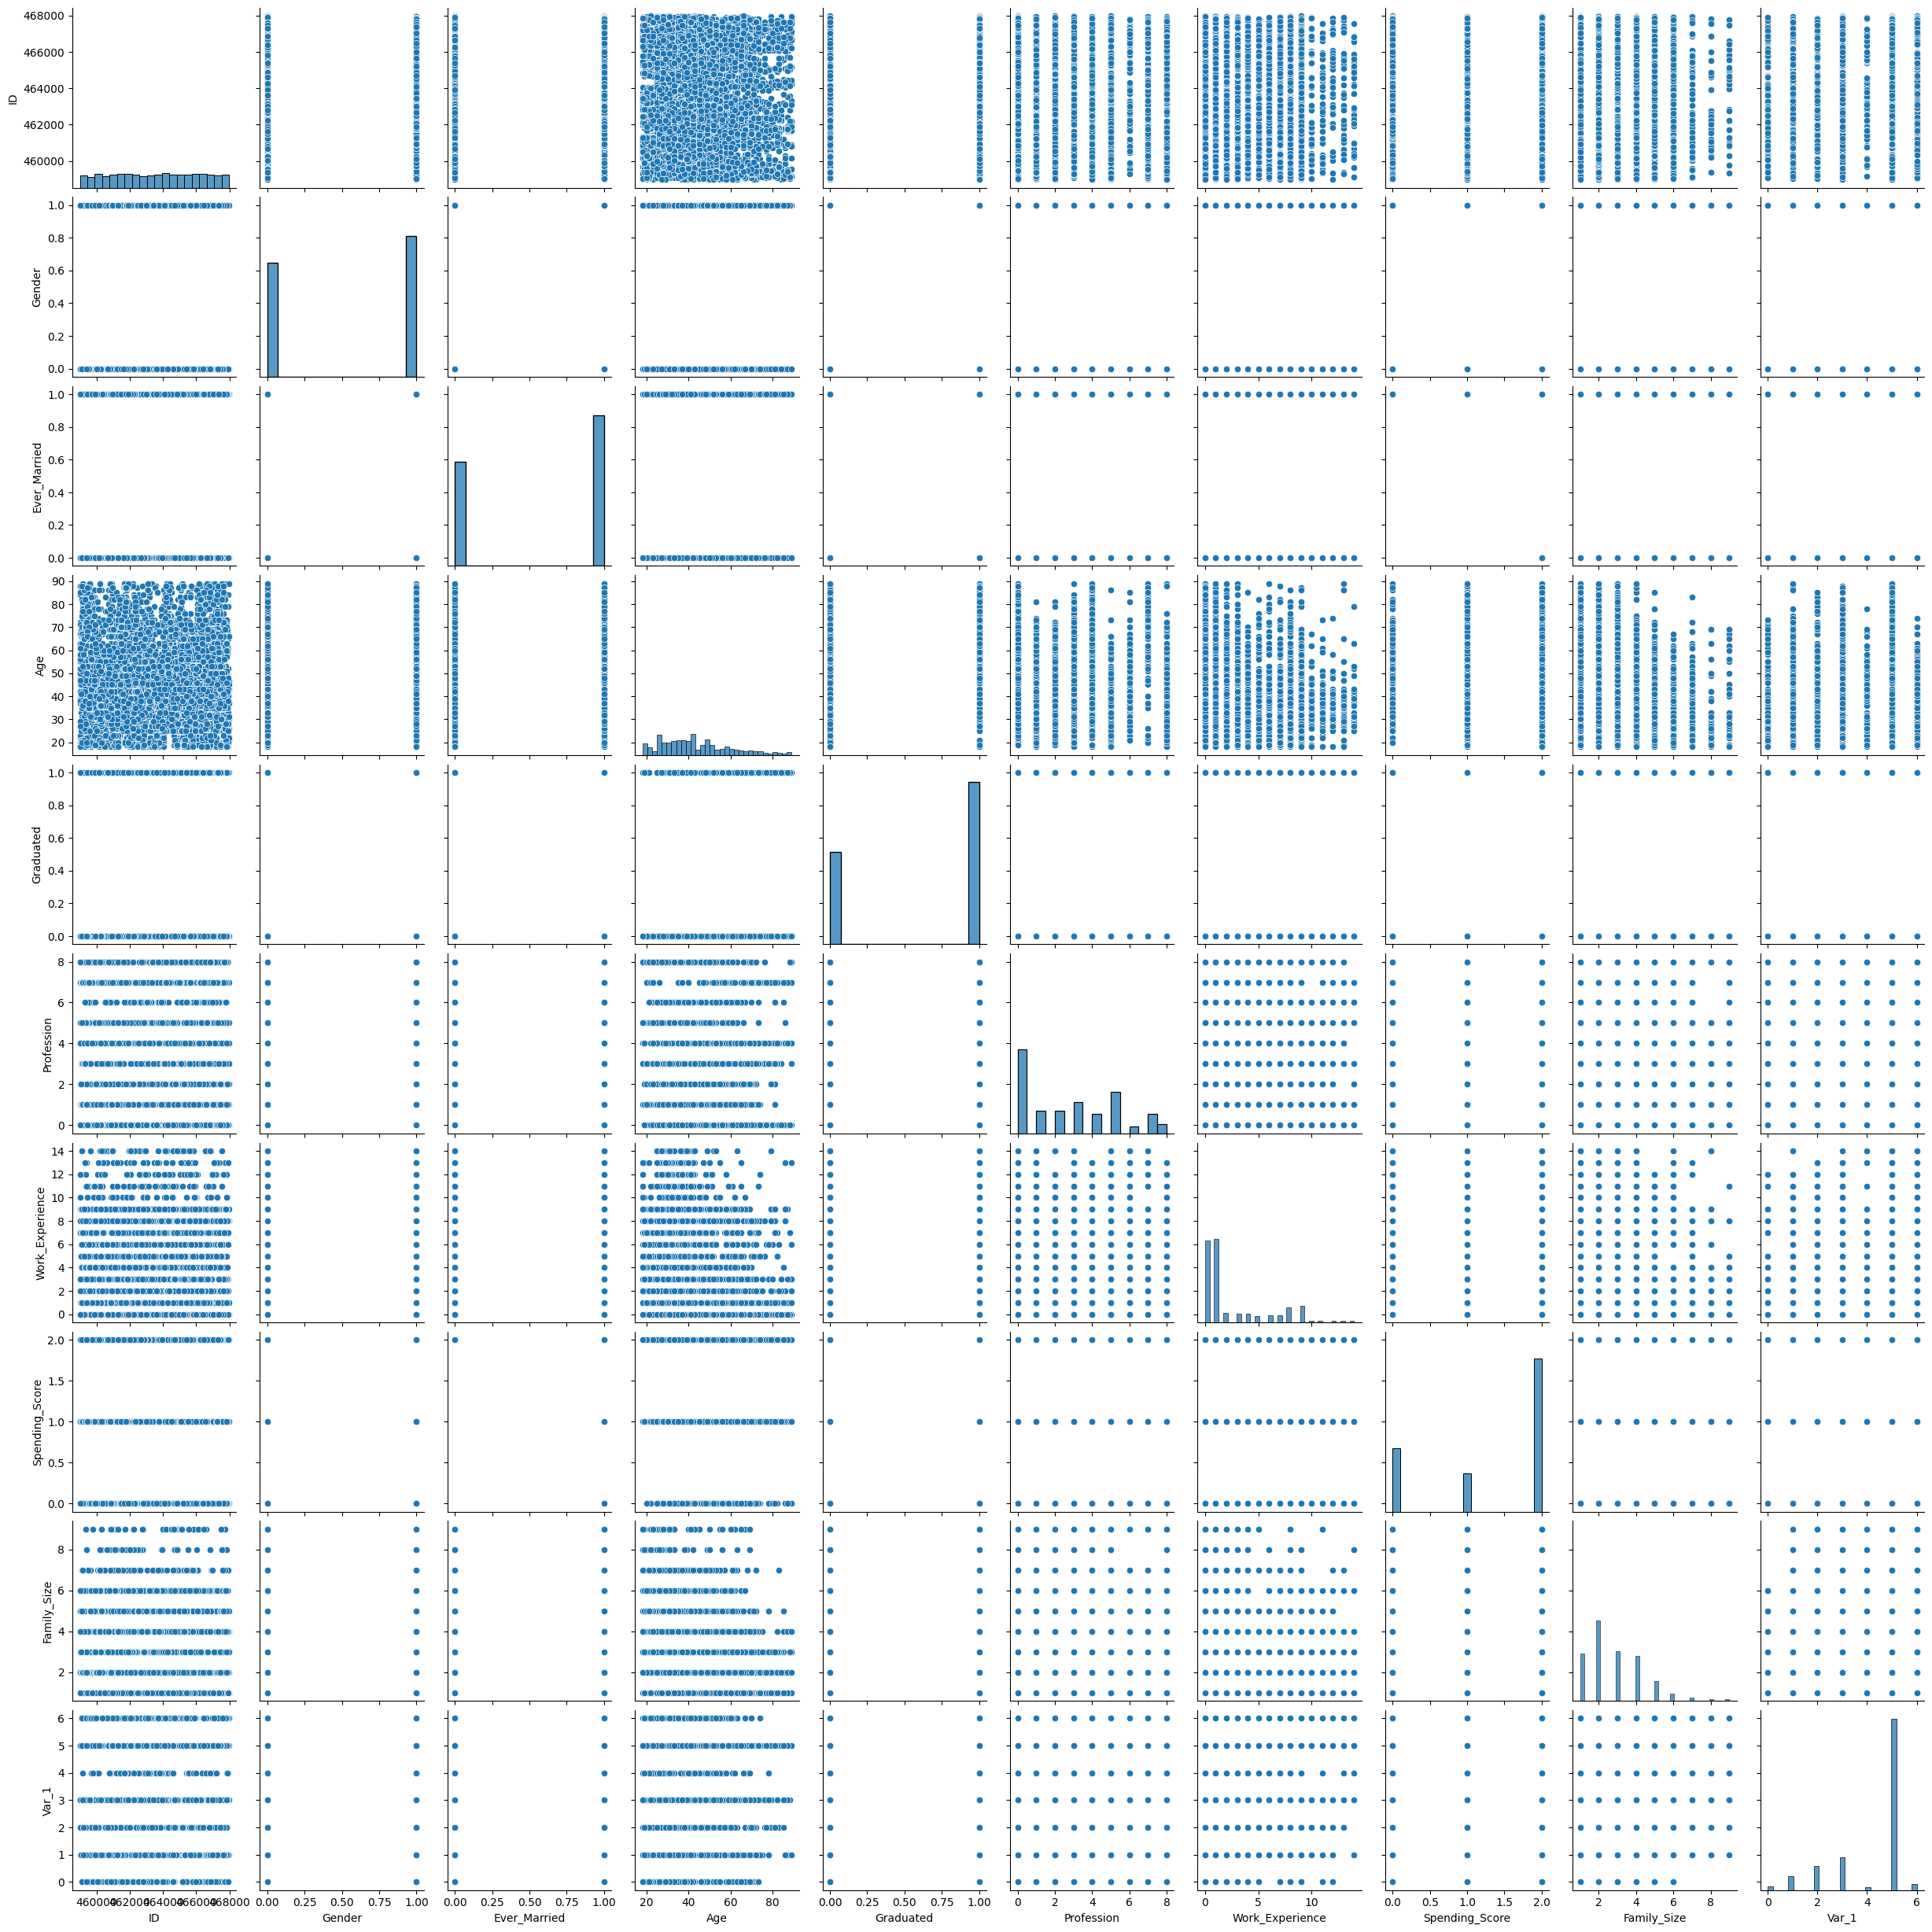

In [492]:
# Analyse the data with a pair plot
sns.pairplot(customer_data)
plt.show()

- For clustering, we use features which show visible spread, variation or separation patterns which is the case for almost all features above.
- However, we drop features that are unique identifiers such as the ID column as well as correlated features. 
- We also drop Var_1 and profession as they have too many features and will dominate

In [493]:
# Scale selected features
df = customer_data[
    [
        "Gender",
        "Ever_Married",
        "Age",
        "Graduated",
        "Work_Experience",
        "Spending_Score",
    ]
]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)  # Dataframe

df_scaled.head().T

,0,1,2,3,4
Gender,0.901454,-1.109319,0.901454,0.901454,0.901454
Ever_Married,-1.203938,0.830607,0.830607,0.830607,-1.203938
Age,-1.303415,1.420092,1.420092,0.754346,-0.698191
Graduated,-1.326157,0.754059,0.754059,-1.326157,0.754059
Work_Experience,-0.478430,-0.478430,-0.772106,-0.772106,-0.478430
Spending_Score,0.761894,0.761894,-0.411402,-1.584697,0.761894


### Select K and Fit Model

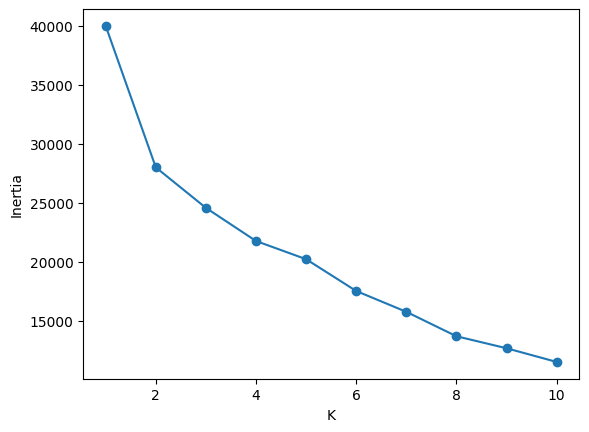

In [494]:
# Random state seed
rseed = 42


# Determine the optimal number of clusters to use
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_


# Plot elbow curve
def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k + 1)]
    plt.plot(range(1, 11), within_cluster_vars, marker="o")
    plt.xlabel("K")
    plt.ylabel("Inertia")
    plt.show()


# Plot elbow curve using scaled dataset (call function)
elbow_Kmeans(df_scaled)

- The elbow is at 2, therefore 2 is our optimal number of clusters(K)

In [495]:
# Fit model with optimal k
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=rseed, max_iter=500)
kmeans.fit(df_scaled)
labels = kmeans.fit_predict(df_scaled)

c:\Users\dsdbo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


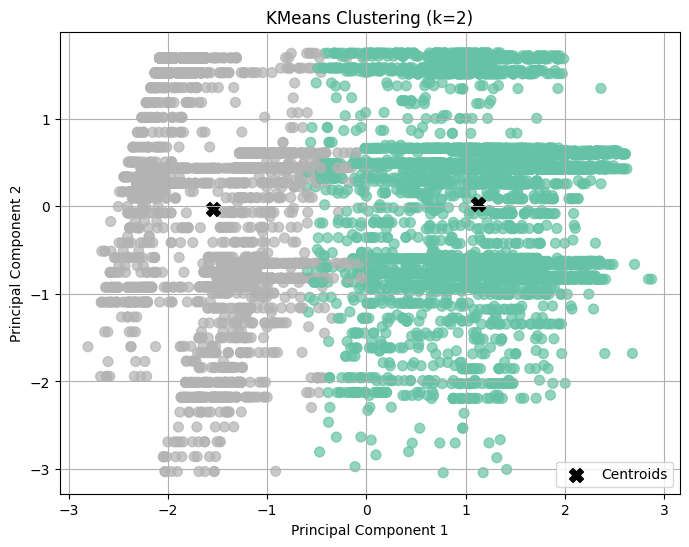

In [496]:
# Reduce dimensions to 2D
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap="Set2", s=50, alpha=0.7)
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centers[:, 0], centers[:, 1], c="black", s=100, marker="X", label="Centroids"
)
plt.title(f"KMeans Clustering (k={optimal_k})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

### Model evaluation and performance

In [497]:
# Count the number of records in each cluster
labels = kmeans.labels_
cluster_counts = pd.Series(labels).value_counts()
print(f"Number of records in each cluster:\n{cluster_counts}")

Number of records in each cluster:
0    3862
1    2803
Name: count, dtype: int64


In [498]:
# Check model performance with the silhouette coefficient
sil_score = silhouette_score(df_scaled, labels, metric="euclidean")
print(f"Silhouette Score for K={optimal_k}: {sil_score}")

Silhouette Score for K=2: 0.2932495405071892


- A Silhouette Score of 0.29 suggests a weak clustering structure. It means the data is somewhat grouped but there's likely an overlap between clusters and some points are not well separated

In [499]:
# Add the predicted cluster label column to the original dataframe
df["Cluster"] = kmeans.labels_
print(df.head())

   Gender  Ever_Married  Age  Graduated  Work_Experience  Spending_Score  \
0       1             0   22          0              1.0               2   
2       0             1   67          1              1.0               2   
3       1             1   67          1              0.0               1   
5       1             1   56          0              0.0               0   
6       1             0   32          1              1.0               2   

   Cluster  
0        1  
2        0  
3        0  
5        0  
6        1  


C:\Users\dsdbo\AppData\Local\Temp\ipykernel_3852\3307453094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cluster"] = kmeans.labels_


In [500]:
cluster_summary = df.groupby("Cluster").mean(numeric_only=True)
print(cluster_summary)

           Gender  Ever_Married        Age  Graduated  Work_Experience  \
Cluster                                                                  
0        0.602796      0.997411  51.928017   0.732522         2.298550   
1        0.481270      0.032822  31.973600   0.506600         3.084552   

         Spending_Score  
Cluster                  
0              0.879337  
1              2.000000  


### Conclusion:

Based on our analysis, we are able to group our customers into 2 segments.

Segment one: Most likely male, mostly married, older citizens, have graduated, lower spending habits and less work experience (older employees normally stick to one profession or place of work as they approach retirement.)

Segment two: Mostly likely female, more likely not married, younger age group, have not graduated, higher spending habits with more work experience (not in years but maybe a greater variety of professions as younger employees are more likely to hop around)